# Time Series RNN in Pytorch

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

# Download historical data for a stock
data = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
data = data[['Close']]  
data = data.values  

scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)

# Convert the data to a numpy array
data_normalized = data_normalized.astype(np.float32)

# Set the sequence length for the time series data
sequence_length = 12

# Create a dataset of sequences from the normalized time series data
# Each input sequence will have a corresponding target sequence shifted by the sequence length
dataset = timeseries_dataset_from_array(
    data_normalized,                  # The normalized time series data
    targets=data_normalized[sequence_length:],  # Targets are shifted by the sequence length
    sequence_length=sequence_length,  # Length of the input sequences
    batch_size=1                      # Batch size of 1 (one sequence per batch)
)

# Convert the dataset to a list of tuples (input_sequence, label)
# Each tuple contains the input sequence and its corresponding target
# Convert each input sequence and label from NumPy arrays to PyTorch tensors
train_inout_seq = [(torch.tensor(x.numpy()), torch.tensor(y.numpy())) for x, y in dataset]

# Define the RNN model class inheriting from PyTorch's nn.Module
class RNN(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size  # Number of features in the hidden state
        # Define the LSTM layer with input size, hidden layer size, and batch_first=True (input shape: batch_size, seq_len, input_size)
        self.rnn = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        # Define a linear layer to map the hidden state output to the desired output size
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq, hidden_cell):
        # Forward pass through the LSTM layer
        # rnn_out contains the output features (h_t) from the last layer of the LSTM
        # hidden_cell contains the hidden and cell states for all layers
        rnn_out, hidden_cell = self.rnn(input_seq, hidden_cell)
        # Pass the output of the LSTM through the linear layer to get the predictions
        # We're only interested in the output of the last time step (rnn_out[:, -1])
        predictions = self.linear(rnn_out[:, -1])
        return predictions, hidden_cell

# Initialize the model with the input size, hidden layer size, and output size
input_size = 1                   # Size of each input feature (e.g., one feature per time step)
hidden_layer_size = 50           # Number of features in the hidden state
output_size = 1                  # Size of the output (e.g., one prediction per sequence)

model = RNN(input_size=input_size, hidden_layer_size=hidden_layer_size, output_size=output_size)
loss_function = nn.MSELoss()     # Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Set the number of training epochs
epochs = 50

# Training loop
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()  # Clear the gradients of all optimized parameters

        # Initialize the hidden state for each sequence
        # The hidden state is initialized with zeros and has the shape (num_layers, batch_size, hidden_layer_size)
        hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size),
                       torch.zeros(1, seq.size(0), model.hidden_layer_size))

        # Reshape the input sequence to match the expected input shape for the LSTM
        # Reshape to (batch_size, sequence_length, input_size)
        seq = seq.view(1, -1, 1)
        # Reshape the labels to match the output shape
        labels = labels.view(1, -1)

        # Forward pass: compute the predicted output
        y_pred, hidden_cell = model(seq, hidden_cell)

        # Compute the loss between the predicted output and the actual labels
        single_loss = loss_function(y_pred, labels)

        # Backward pass: compute the gradients
        single_loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()

    # Print the loss every 25 epochs
    if i % 25 == 0:
        print(f'Epoch {i} loss: {single_loss.item()}')

# Print the loss after the final epoch
print(f'Epoch {epochs} loss: {single_loss.item()}')



2024-08-12 16:47:13.280357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%%**********************]  1 of 1 completed
Epoch 0 loss: 0.00030405455618165433
Epoch 25 loss: 0.00015972739493008703
Epoch 50 loss: 3.7844587495783344e-05


In [2]:
import numpy as np


# Initialize test inputs with the last sequence_length values from the normalized data
fut_pred=12

test_inputs = data_normalized[-sequence_length:].tolist()

model.eval()

for i in range(fut_pred):
    # Ensure we are slicing the list correctly and it contains numerical values
    seq_input = test_inputs[-sequence_length:]
    
    # Flatten nested lists and convert to FloatTensor
    seq_input = [item for sublist in seq_input for item in sublist]
    seq = torch.FloatTensor(seq_input).view(1, -1, 1)  # reshape to (batch_size, sequence_length, input_size)
    
    with torch.no_grad():
        # Initialize hidden state
        hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                       torch.zeros(1, 1, model.hidden_layer_size))
        
        # Make prediction and append to test_inputs
        prediction, hidden_cell = model(seq, hidden_cell)
        test_inputs.append([prediction.item()])  # Append as a list to maintain consistency

# Convert test_inputs back to numpy array for inverse transformation
test_inputs_np = np.array(test_inputs).reshape(-1, 1)


In [3]:
actual_predictions = scaler.inverse_transform(test_inputs_np[sequence_length:]) # Only transform predictions

In [12]:
data2 = yf.download('AAPL', start='2020-01-02', end='2020-01-18')
data2 = data2[['Close']]  
data2 = data2.values  

[*********************100%%**********************]  1 of 1 completed


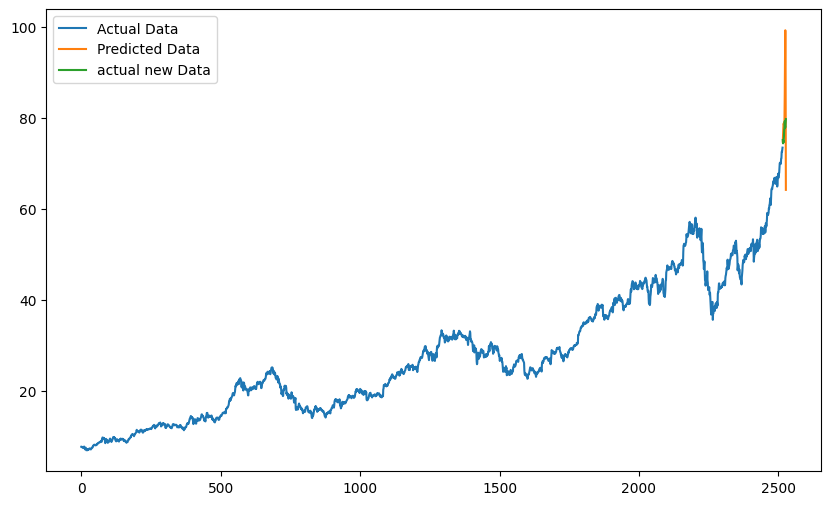

In [15]:
# Plot the results
plt.figure(figsize=(10,6))
plt.plot(data, label='Actual Data')
plt.plot(range(len(data),len(data)+12), actual_predictions, label='Predicted Data')
plt.plot(range(len(data),len(data)+12), data2, label='actual new Data')
plt.legend()
plt.show()

In [21]:
data3 = yf.download('AAPL', start='2020-01-02', end='2020-03-18')
data3 = data3[['Close']]  
data3 = data3.values  

[*********************100%%**********************]  1 of 1 completed


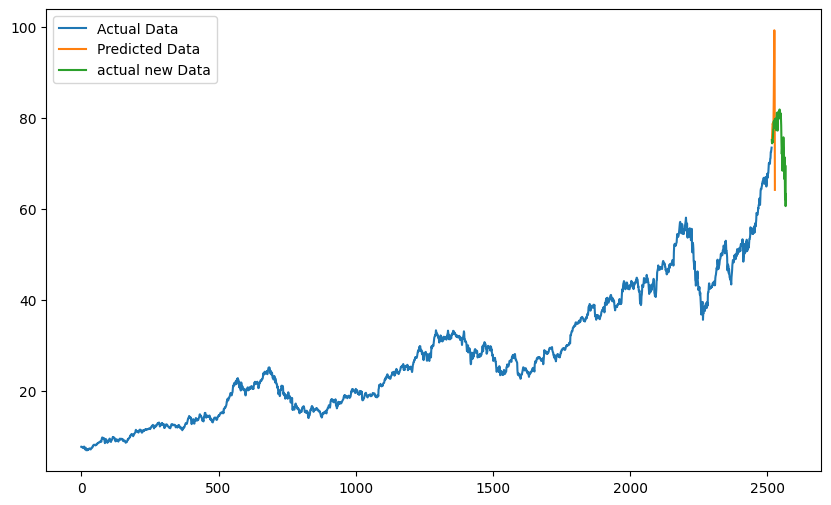

In [24]:
# Plot the results
plt.figure(figsize=(10,6))
plt.plot(data, label='Actual Data')
plt.plot(range(len(data),len(data)+12), actual_predictions, label='Predicted Data')
plt.plot(range(len(data),len(data)+52), data3, label='actual new Data')
plt.legend()
plt.show()

Findings are that based on this small sample the RNN was able to predict the series but seems to have predicted the overall trend over an sooner period than how the trend actually progressed over time.